In [1]:
import json
import os
import pickle
import sys
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

In [2]:
with open(os.path.join(dirs['out']['inf'], 'itc-per-category.pickle'), 'rb') as handle:
    itc = pickle.load(handle)
with open(os.path.join(dirs['out']['inf'], 'pfc-per-category.pickle'), 'rb') as handle:
    pfc = pickle.load(handle)

In [16]:
tim = np.arange(-200, 650, step=1) + 25

x = []
for key in itc.keys():
    y = smooth(itc[key], sigma=2)
    y -= y[:, (tim > -50) & (tim < 0)].mean(1).reshape(-1, 1)
    x.append((y / 50 * 1000).mean(0).max())

z = []
for key in itc.keys():
    y = smooth(pfc[key], sigma=2)
    y -= y[:, (tim > -50) & (tim < 0)].mean(1).reshape(-1, 1)
    z.append((y / 50 * 1000).mean(0).max())

from scipy.stats import ttest_rel as t

np.mean(z[0:2]) - np.mean(z[2:4])

0.1284321610818796

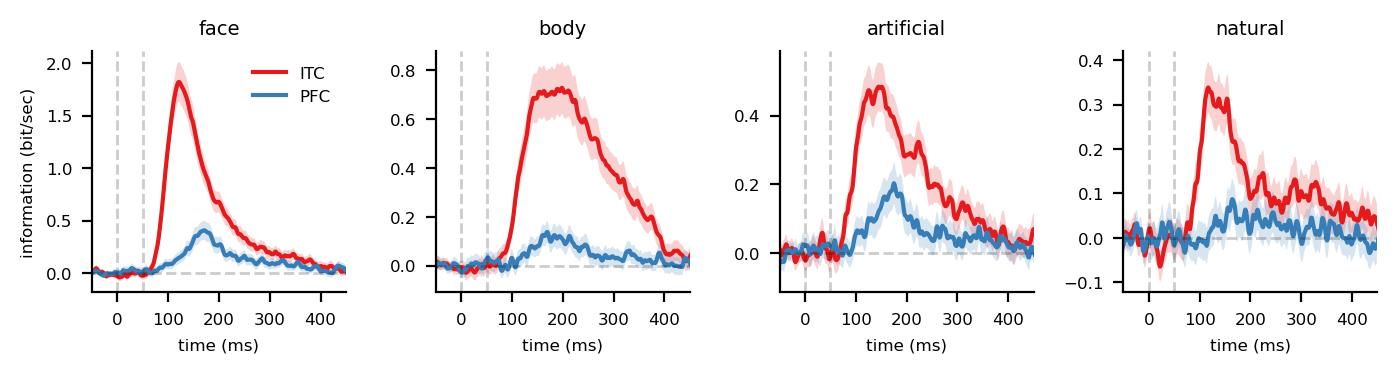

In [3]:
tim = np.arange(-200, 650, step=1) + 25
sns.set_palette('Set1')

cm = 1 / 2.54
fig, axs = plt.subplots(1, 4, figsize=(18 * cm, 5 * cm), dpi=200, sharey=False)

for ax, category in zip(axs.flat, pfc.keys()):
    
    for region_name, region in zip(['ITC', 'PFC'], [itc, pfc]):
        X = region[category] / 50 * 1000
        X = smooth(X, sigma=2)
        X -= X[:, (tim > -50) & (tim < 0)].mean(1).reshape(-1, 1)
        ax.plot(tim, X.mean(0), label=region_name)
        ax.fill_between(tim, \
            X.mean(0) + 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            X.mean(0) - 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            alpha=.2, label='_nolegend_')
        ax.set_title(category, fontsize=7)
        # break

for ax in axs.flat:
    ax.axvline(0, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.axvline(50, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.set_xlim(-50, 450)
    ax.set_xlabel('time (ms)', fontsize=6)
    ax.set_ylabel('')
    ax.axhline(0, color='k', ls='--', lw=1, alpha=.2, label='_nolegend_')
    ax.tick_params(axis='both', which='major', labelsize=6)

axs[0].legend(frameon=False, fontsize=6)
axs[0].set_ylabel('information (bit/sec)', fontsize=6)

sns.despine()
fig.tight_layout()

plt.savefig('information1.pdf')

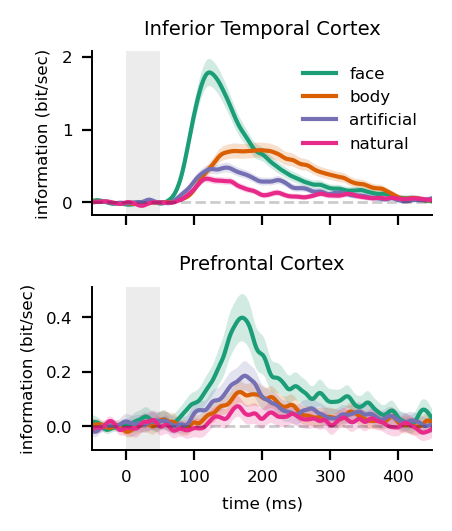

In [4]:
tim = np.arange(-200, 650, step=1) + 25
sns.set_palette('Dark2')

cm = 1 / 2.54
fig, axs = plt.subplots(2, 1, figsize=(6 * cm, 7 * cm), dpi=200, sharex=True)

for ax, region, region_name in zip(axs.flat, [itc, pfc], ['Inferior Temporal Cortex', 'Prefrontal Cortex']):
    for category in pfc.keys():
        X = region[category] / 50 * 1000
        X = smooth(X, sigma=5)
        X -= X[:, (tim > -50) & (tim < 0)].mean(1).reshape(-1, 1)
        ax.plot(tim, X.mean(0), label=category)
        ax.fill_between(tim, \
            X.mean(0) + 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            X.mean(0) - 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            alpha=.2, label='_nolegend_')
    ax.set_title(region_name, fontsize=7)

for ax in axs.flat:
    ax.set_xlim(-50, 450)
    ax.set_ylabel('')
    ax.axhline(0, color='k', ls='--', lw=1, alpha=.2, label='_nolegend_')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylabel('information (bit/sec)', fontsize=6)
    ylim = ax.get_ylim()
    ax.fill_between([0, 50], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.15, edgecolor=None)
    ax.set_ylim(ylim)
    plt.setp(ax.spines.values(), linewidth=.7)

axs[1].set_xlabel('time (ms)', fontsize=6)
axs[0].legend(frameon=False, fontsize=6)

sns.despine()
# sns.despine(left=True)
fig.tight_layout()

plt.savefig('information2.pdf')

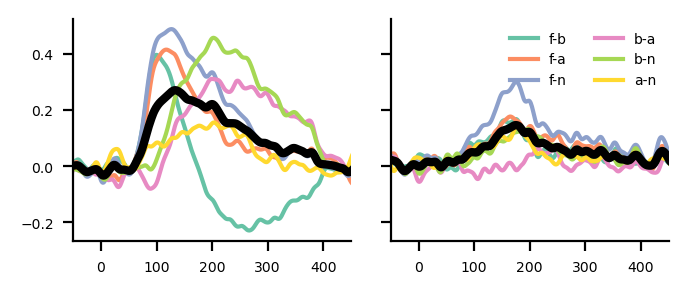

In [5]:
from itertools import combinations as c

sns.set_palette("Set2")

cm=1/2.54
fig, axs = plt.subplots(1, 2, figsize=(9*cm, 4*cm), dpi=200, sharey=True)

for ax, region in zip(axs.flat, [itc, pfc]):

    _mi = []
    for k1, k2 in c(pfc.keys(), r=2):
        g1 = smooth(np.array(region[k1].mean(0)), sigma=5)
        g2 = smooth(np.array(region[k2].mean(0)), sigma=5)
        mi = ((g1-g2)) / (g1+g2)
        mi -= mi[tim<0].mean()
        # mi = np.abs(mi)
        ax.plot(tim, mi, label=k1[0]+"-"+k2[0])
        _mi.append(mi)
    ax.plot(tim, np.mean(_mi, 0), lw=3, c='k')

    ax.tick_params(axis='both', which='major', labelsize=5)
    # ax.set_ylim(-.05, .6)
    ax.set_xlim(-50, 450)

axs[1].legend(frameon=False, fontsize=5, ncol=2)
sns.despine()
fig.tight_layout()

In [6]:
from itertools import combinations as c
from scipy import stats

sns.set_palette("Set1")

# ax = axs

inv = {"itc": [], "pfc": []}
for name, region in zip(["itc", "pfc"], [itc, pfc]):
    ks = inv[name]
    for bt in tqdm(range(200)):
        ind = np.random.choice(region['face'].shape[0], region['face'].shape[0], replace=True)
        _ks = []
        for i in range(region['face'].shape[1]):
            # rvs = [region['body'][:,i].mean(0), region['artificial'][:,i].mean(0), region['natural'][:,i].mean(0)]
            rvs = [region['face'][ind,i].mean(0), region['body'][ind,i].mean(0), region['artificial'][ind,i].mean(0), region['natural'][ind,i].mean(0)]
            # rvs = [region['face'][:,i], region['body'][:,i], region['artificial'][:,i], region['natural'][:,i]]
            rvs = np.array(rvs).flatten()
            _ks.append(1/stats.kstest(rvs, cdf='uniform')[0])
        ks.append(_ks)

# cm=1/2.54
# fig, axs = plt.subplots(1, 1, figsize=(6*cm, 4*cm), dpi=200, sharey=True)

# for region in [itc, pfc]:

#     mi = []
#     for i in range(region['face'].shape[1]):
#         # rvs = [region['body'][:,i].mean(0), region['artificial'][:,i].mean(0), region['natural'][:,i].mean(0)]
#         rvs = [region['face'][:,i].mean(0), region['body'][:,i].mean(0), region['artificial'][:,i].mean(0), region['natural'][:,i].mean(0)]
#         # rvs = [region['face'][:,i], region['body'][:,i], region['artificial'][:,i], region['natural'][:,i]]
#         rvs = np.array(rvs).flatten()
#         mi.append(1/stats.kstest(rvs, cdf='uniform')[0])
#     ax.plot(tim, mi)

# ax.tick_params(axis='both', which='major', labelsize=5)
# # ax.set_ylim(-.05, .6)
# ax.set_xlim(-50, 450)

# axs[1].legend(frameon=False, fontsize=5, ncol=2)
sns.despine()
fig.tight_layout()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

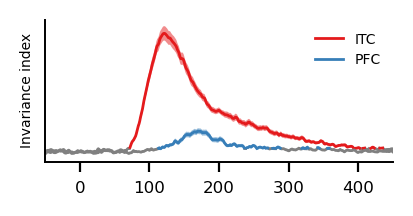

In [7]:
cm=1/2.54
fig, axs = plt.subplots(1, 1, figsize=(5.5*cm, 3*cm), dpi=200, sharey=True)
ax = axs

sns.set_palette("Set1")

for region in ["itc", "pfc"]:
    X = np.array(inv[region])
    X = smooth(X, sigma=1)
    X = X - X[:, tim<0].mean()
    sig_ind = X.mean(0) > 3*(X.mean(0)[tim<0]).std()
    
    nsig = np.nan * X
    nsig[:, ~sig_ind] = X[:, ~sig_ind]
    ax.plot(tim, np.mean(nsig, 0), lw=1, c='gray', label="_nolegend_")
    ax.fill_between(tim, np.mean(nsig, 0) + np.std(nsig, 0), np.mean(nsig, 0) - np.std(nsig, 0), alpha=.5, facecolor='gray', label="_nolegend_")

    sig = np.nan * X
    sig[:, sig_ind] = X[:, sig_ind]
    ax.plot(tim, sig.mean(0), lw=1)
    ax.fill_between(tim, np.mean(sig, 0) + np.std(sig, 0), np.mean(sig, 0) - np.std(sig, 0), alpha=.5, label="_nolegend_")

# ax.tick_params(axis='both', which='major', labelsize=5)
# # ax.set_ylim(-.05, .6)
ax.set_xlim(-50, 450)

# axs[1].legend(frameon=False, fontsize=5, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=6)
# ax.set_xlabel(ax.get_xlabel(), fontsize=6)
ax.set_xlabel("")
ax.set_ylabel("Invariance index", fontsize=5)
ax.set_yticks([])
plt.setp(ax.spines.values(), linewidth=.7)
plt.legend(["ITC", "PFC"], frameon=False, fontsize=5)

sns.despine()
fig.tight_layout()

plt.savefig('invariance.pdf')

In [8]:
from scipy import stats

tim = np.arange(-200, 650, step=1) + 25

itc_onsets = {'face': [], 'body': [], 'artificial': [], 'natural': []}
pfc_onsets = {'face': [], 'body': [], 'artificial': [], 'natural': []}
itc_peak_times = {'face': [], 'body': [], 'artificial': [], 'natural': []}
pfc_peak_times = {'face': [], 'body': [], 'artificial': [], 'natural': []}

for rep in range(250):
    np.random.seed(rep)
    for category in pfc.keys():
        # ITC
        X = itc[category]
        X = smooth(X, sigma=5)
        X = X[np.random.choice(X.shape[0], X.shape[0], replace=True)].mean(0)

        bl = X[(tim <= 0) & (tim > -150)]
        th = 3 * bl.std() + bl.mean()
        sw = np.convolve(X>th, .1*np.ones((1, 10)).flatten(), mode='same')
        sw[tim<0] = 0
        os = tim[np.argmax(sw)-10]
        if os < 200 and os > 50:
            itc_onsets[category].append(os)
        else:
            itc_onsets[category].append(np.nan)
        pt = tim[np.argmax(X)]
        if pt < 250 and pt > 50:
            itc_peak_times[category].append(pt)
        else:
            itc_peak_times[category].append(np.nan)

        # PFC
        X = pfc[category]
        X = smooth(X, sigma=5)
        X = X[np.random.choice(X.shape[0], X.shape[0], replace=True)].mean(0)

        bl = X[(tim <= 0) & (tim > -150)]
        th = 3 * bl.std() + bl.mean()
        sw = np.convolve(X>th, .1*np.ones((1, 10)).flatten(), mode='same')
        sw[tim<0] = 0
        os = tim[np.argmax(sw)-10]
        if os < 200 and os > 50:
            pfc_onsets[category].append(os)
        else:
            pfc_onsets[category].append(np.nan)
        pt = tim[np.argmax(X)]
        if pt < 250 and pt > 50:
            pfc_peak_times[category].append(pt)
        else:
            pfc_peak_times[category].append(np.nan)
    

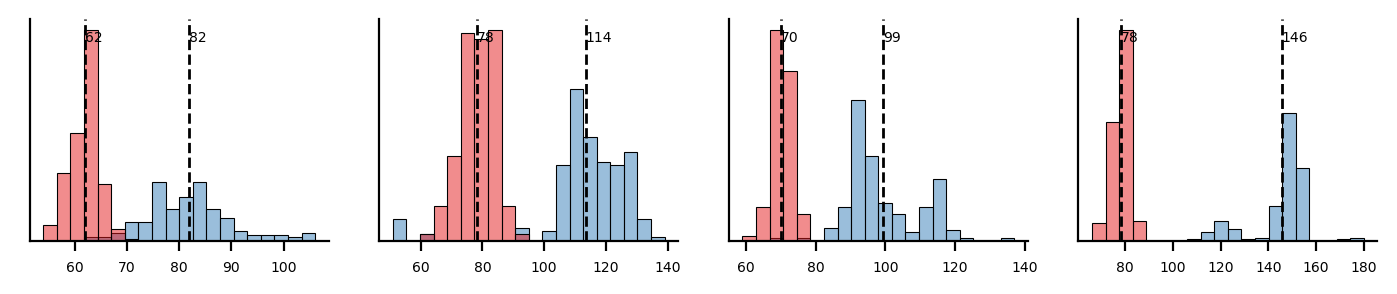

In [9]:
cm = 1/2.54
fig, axs = plt.subplots(1,4,figsize=(18*cm, 4*cm), dpi=200)

for ax, category in zip(axs.flat, pfc.keys()):
    x = np.array(itc_onsets[category])
    y = np.array(pfc_onsets[category])
    df = pd.DataFrame({'onsets': np.concatenate((x, y)),
                       'region': np.concatenate([np.full(np.shape(x), 'ITC', dtype=object), 
                                 np.full(np.shape(y), 'PFC', dtype=object)])})
    sns.histplot(data=df, x="onsets", hue="region", ax=ax, bins=20)
    
    min_ylim, max_ylim = ax.get_ylim()
    ax.axvline(np.nanmean(x), color='k', linestyle='dashed', linewidth=1)
    ax.text(np.nanmean(x)*1, max_ylim*0.9, '{:.0f}'.format(np.nanmean(x)), fontsize=5)
    ax.axvline(np.nanmean(y), color='k', linestyle='dashed', linewidth=1)
    ax.text(np.nanmean(y)*1, max_ylim*0.9, '{:.0f}'.format(np.nanmean(y)), fontsize=5)

    ax.set_yticks([])

for ax, title in zip(axs.flat, pfc.keys()):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend([], frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=5)

sns.despine()
fig.tight_layout()

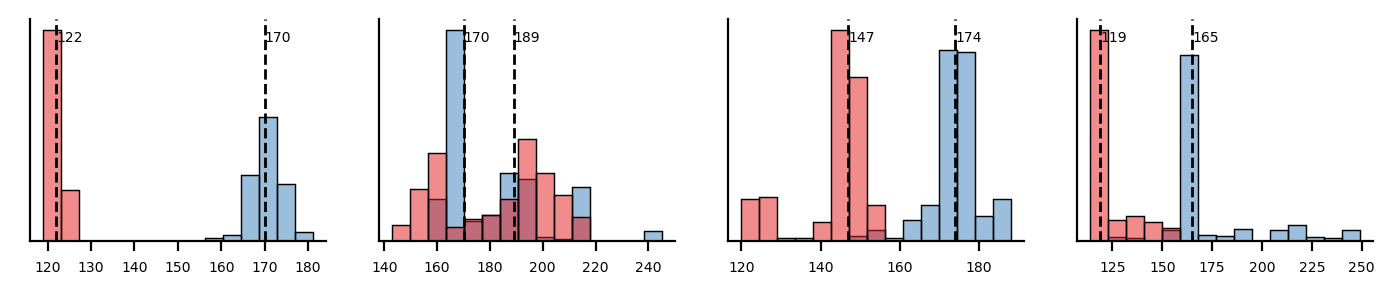

In [11]:
cm = 1/2.54
fig, axs = plt.subplots(1,4,figsize=(18*cm, 4*cm), dpi=200)

for ax, category in zip(axs.flat, pfc.keys()):
    x = np.array(itc_peak_times[category])
    y = np.array(pfc_peak_times[category])
    df = pd.DataFrame({'onsets': np.concatenate((x, y)),
                       'region': np.concatenate([np.full(np.shape(x), 'ITC', dtype=object), \
                                 np.full(np.shape(y), 'PFC', dtype=object)])})
    sns.histplot(data=df, x="onsets", hue="region", ax=ax, bins=15)
    
    min_ylim, max_ylim = ax.get_ylim()
    ax.axvline(np.nanmedian(x), color='k', linestyle='dashed', linewidth=1)
    ax.text(np.nanmedian(x)*1, max_ylim*0.9, '{:.0f}'.format(np.nanmedian(x)), fontsize=5)
    ax.axvline(np.nanmedian(y), color='k', linestyle='dashed', linewidth=1)
    ax.text(np.nanmedian(y)*1, max_ylim*0.9, '{:.0f}'.format(np.nanmedian(y)), fontsize=5)
    ax.set_yticks([])

for ax, title in zip(axs.flat, pfc.keys()):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend([], frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=5)

sns.despine()
fig.tight_layout()

In [12]:
n = len(itc_onsets['face'])
df = pd.DataFrame({
    'times': np.concatenate((itc_onsets['face'], itc_onsets['body'], itc_onsets['artificial'], itc_onsets['natural'], 
                             pfc_onsets['face'], pfc_onsets['body'], pfc_onsets['artificial'], pfc_onsets['natural'],
                             itc_peak_times['face'], itc_peak_times['body'], itc_peak_times['artificial'], itc_peak_times['natural'],
                             pfc_peak_times['face'], pfc_peak_times['body'], pfc_peak_times['artificial'], pfc_peak_times['natural'])),
    'region': np.concatenate((np.full(4*n, 'ITC', dtype=object), np.full(4*n, 'PFC', dtype=object), 
                              np.full(4*n, 'ITC', dtype=object), np.full(4*n, 'PFC', dtype=object))),
    'category': np.concatenate((np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object),
                                np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object),
                                np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object),
                                np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object))),
    'type': np.concatenate((np.full(8*n, 'onset', dtype=object), np.full(8*n, 'peak', dtype=object)))
})
df.head()

,times,region,category,type
0,60.0,ITC,face,onset
1,65.0,ITC,face,onset
2,64.0,ITC,face,onset
3,63.0,ITC,face,onset
4,62.0,ITC,face,onset


In [21]:
from scipy.stats import norm

reported_time = "peak"
print(reported_time)
print("")
for category in ["face", "body", "artificial", "natural"]:
    print(category)

    gi = df[(df.region=="ITC").values & (df.category==category).values & (df.type==reported_time).values].times.values
    gp = df[(df.region=="PFC").values & (df.category==category).values & (df.type==reported_time).values].times.values

    gi = gi[~np.isnan(gi)]
    gp = gp[~np.isnan(gp)]

    print(f"itc = {gi.mean():.0f} +- {gi.std():.0f}")
    print(f"pfc = {gp.mean():.0f} +- {gp.std():.0f}")
    print(f"dt = {gp.mean() - gi.mean():.0f}")
    p = norm.cdf((gi.mean() - gp.mean()) / gp.std())
    print(f"p = {p:.9f}")

    print("")

peak

face
itc = 122 +- 1
pfc = 170 +- 3
dt = 48
p = 0.000000000

body
itc = 183 +- 20
pfc = 180 +- 19
dt = -2
p = 0.544656281

artificial
itc = 143 +- 9
pfc = 174 +- 6
dt = 31
p = 0.000000253

natural
itc = 124 +- 10
pfc = 174 +- 24
dt = 50
p = 0.017423508



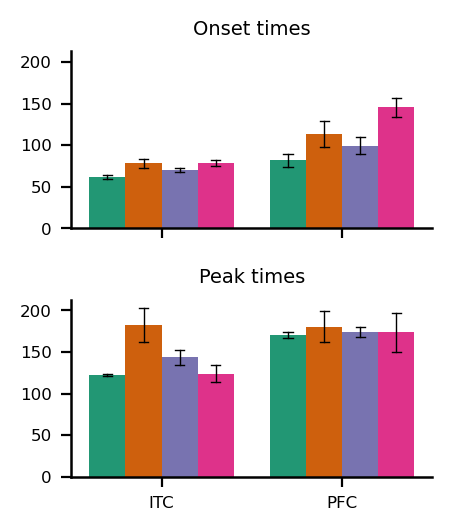

In [11]:
# sns.set_palette("tab10")

fg = sns.FacetGrid(data=df, row="type")
fg.figure.set_size_inches((6*cm, 7*cm))
fg.figure.set_dpi(200)
fg.map_dataframe(sns.barplot, y="times", x="region", hue="category", errorbar='sd', \
    palette='Dark2', errwidth=.5, errcolor='k', capsize=.05, saturation=.9)
# sns.barplot(y="times", x="region", hue="category", data=df, ci='sd', group='type')

for ax, title in zip(fg.axes.flat, ["Onset times", "Peak times"]):
    # ax.set_ylim(50, 200)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_title(title, fontsize=7)
    # ax.set_xlabel(ax.get_xlabel(), fontsize=6)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.setp(ax.spines.values(), linewidth=.9)

fg.fig.tight_layout()
plt.savefig('information-onsets.pdf')

# Information Accumulation Time (Onset to Peak Time )

In [12]:
n = len(itc_onsets['face'])
df = pd.DataFrame({
    'times': np.concatenate((np.array(itc_peak_times['face']) - np.array(itc_onsets['face']), \
                             np.array(itc_peak_times['body']) - np.array(itc_onsets['body']), 
                             np.array(itc_peak_times['artificial']) - np.array(itc_onsets['artificial']), 
                             np.array(itc_peak_times['natural']) - np.array(itc_onsets['natural']), 
                             np.array(pfc_peak_times['face']) - np.array(pfc_onsets['face']), 
                             np.array(pfc_peak_times['body']) - np.array(pfc_onsets['body']), 
                             np.array(pfc_peak_times['artificial']) - np.array(pfc_onsets['artificial']), 
                             np.array(pfc_peak_times['natural']) - np.array(pfc_onsets['natural']))),
    'region': np.concatenate((np.full(4*n, 'ITC', dtype=object), np.full(4*n, 'PFC', dtype=object))),
    'category': np.concatenate((np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object),
                                np.full(n, 'face', dtype=object), np.full(n, 'body', dtype=object), np.full(n, 'artificial', dtype=object), np.full(n, 'natural', dtype=object)))
})
df.head()

,times,region,category
0,63.0,ITC,face
1,57.0,ITC,face
2,58.0,ITC,face
3,58.0,ITC,face
4,58.0,ITC,face


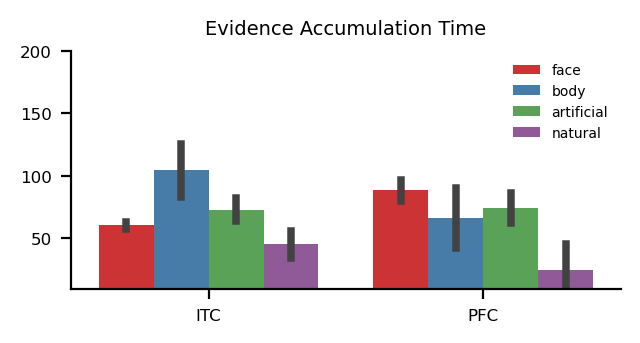

In [13]:
sns.barplot(x="region", y="times", hue="category", errorbar='sd', data=df, estimator=np.mean)

fig = plt.gcf()
fig.set_size_inches((9*cm, 4*cm))
fig.set_dpi(200)

ax = plt.gca()
ax.set_ylim(10, 200)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_title("Evidence Accumulation Time", fontsize=7)
ax.set_xlabel("")
ax.set_ylabel("")

plt.legend(frameon=False, fontsize=5)

sns.despine()

None